In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
from constant import *
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define the evolution of the amount in 401k account 
def y(t, x):
    n, e, s = x
    if t <= T_R:
        return detEarning[t] * (1+gGDP[int(s)]) * e + (1-e) * welfare
    else:
        return detEarning[t]

def gn(t, x, r):
    n,e,s = x
    if t <= T_R and e == 1:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = n + y(t, x) * yi
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur 

def transition(x,t,s_next):
    n, e, s = x
    n_next = gn(t, x, (r_b[s]+r_k[s_next])/2)
    x_next = []
    p_next = []
    if t >= T_R:
        return [n_next, 0, s_next]
    else:
        if e == 1:
            for e_next in [0,1]:
                x_next.append([n_next,e_next, s_next])
            prob_next = [Pe[s,e], 1 - Pe[s,e]]
        else:
            for e_next in [0,1]:
                x_next.append([n_next,e_next, s_next])
            prob_next = [1-Pe[s,e], Pe[s,e]]
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]]

In [3]:
x0 = [0,1,1] # n,e,s
numAgents = 1000
numEcons = 500

In [4]:
import quantecon as qe
import random as rd
mc = qe.MarkovChain(Ps)
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcons)]

def simulation(i):
    track = np.zeros((T_max - T_min,4))
    econState = EconStates[i//numAgents]
    alive = True
    x = x0
    for t in range(1,len(econState)-1):
        if rd.random() > Pa[t]:
            alive = False
        if alive:
            track[t, 3] = 1
            s_next = econState[t+1]
            track[t,0] = x[0]
            track[t,1] = x[1]
            track[t,2] = x[2]
            x = transition(x,t,s_next)
    return track

In [5]:
# %%time
# pool = Pool()
# agents = pool.map(simulation, list(range(numAgents*numEcons)))
# pool.close()

In [6]:
nn = np.zeros((T_max-T_min, numAgents*numEcons))
ee = np.zeros((T_max-T_min, numAgents*numEcons))
ss = np.zeros((T_max-T_min, numAgents*numEcons))
live = np.zeros((T_max-T_min, numAgents*numEcons))
def separateAttributes(agents):
    for i in range(numAgents*numEcons):
        nn[:,i] = agents[i][:,0]
        ee[:,i] = agents[i][:,1]
        ss[:,i] = agents[i][:,2]
        live[:,i] = agents[i][:,3]

In [7]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(T_max):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(live[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(T_max):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(live[i,:] == 1)]))
    return np.array(means)

In [8]:
NNmean = np.load("empirical/nnMean.npy")
NN85 = np.load("empirical/nn85.npy")
NN90 = np.load("empirical/nn90.npy")

In [9]:
# for yi in np.linspace(0,0.05,20):
#     pool = Pool()
#     agents = pool.map(simulation, list(range(numAgents*numEcons)))
#     pool.close()
#     separateAttributes(agents)
#     print(yi)
#     plt.figure()
#     plt.plot(meanForPeopleWholive(nn), label = "simulation")
#     plt.plot(NNmean, label = "mean")
#     plt.plot(NN85, label = "85%")
#     plt.plot(NN90, label = "90%")
#     plt.legend()
#     plt.show()

0.025


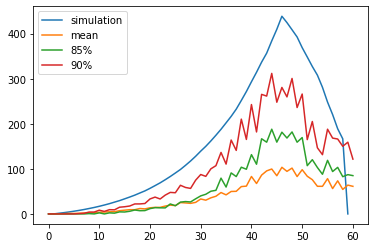

In [10]:
yi = 0.025
pool = Pool()
agents = pool.map(simulation, list(range(numAgents*numEcons)))
pool.close()
separateAttributes(agents)
print(yi)
plt.figure()
plt.plot(meanForPeopleWholive(nn), label = "simulation")
plt.plot(NNmean, label = "mean")
plt.plot(NN85, label = "85%")
plt.plot(NN90, label = "90%")
plt.legend()
plt.show()